## Matrix formulation of Fresnel coefficients for multilayers


In [6]:
import cmath 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp


For a given incident angle and wavelength, we compute 

- the wavevectors $k_i$ in all media
- the in-plane wavevector $k_x$
- the $k_z$ components in all media 

From there we iterate over the number of interfaces and compute the matrix associated with each interface, and its product with the matrix from previous iterations.

The multi-interface complex reflection and transmission coefficients are obtained from the elements $M_{11}$ and $M_{21}$


In [7]:
def multilayer(wavelength, theta, epsilon, thickness, polarisation):
    
    Nlay = len(epsilon)
    
    k0 = 2*np.pi/wavelength
    
    n1 = cmath.sqrt(epsilon[0])
    k1 = n1 * k0
    k_x = k1 * cmath.sin(theta)
    
    k = [cmath.sqrt(epsi)*k0 for epsi in epsilon]
    kz = [cmath.sqrt(ki**2 - k_x**2) for ki in k]
    
    
    ## calculate the transition matrix M
    M11 = M22 = 1.0 + 0j
    M21 = M12 = 0.0 + 0j
    
  
    Mi11 = Mi12 = Mi21 = Mi22 = 1 + 0j
    
    # empty 2x2 complex matrix
    M = np.zeros([2,2])+0j
    M_tmp = np.zeros([2,2])+0j

     
    for il in range(Nlay-1):
        if polarisation == 'p':
            Ki = (epsilon[il] / epsilon[il+1]) * (kz[il+1] / kz[il])
        elif polarisation == 's':
            Ki = kz[il+1] / kz[il]
                
        phasei = np.exp(1j*thickness[il]*kz[il])   
         
        Mi11 = 0.5*(1+Ki) / phasei
        Mi21 = 0.5*(1-Ki) * phasei
        Mi12 = 0.5*(1-Ki) / phasei
        Mi22 = 0.5*(1+Ki) * phasei
        
        M_tmp[0,0] = 0.5*(1+Ki) / phasei
        M_tmp[1,0] = 0.5*(1-Ki) * phasei
        M_tmp[0,1] = 0.5*(1-Ki) / phasei
        M_tmp[1,1] = 0.5*(1+Ki) * phasei
        
        M = M * M_tmp
         
        M11new = M11*Mi11 + M12*Mi21
        M21new = M21*Mi11 + M22*Mi21
        M12new = M11*Mi12 + M12*Mi22
        M22new = M21*Mi12 + M22*Mi22
         
        M11 = M11new
        M12 = M12new
        M21 = M21new
        M22 = M22new
         
    
    t = 1 / M11
    r = M21 * t     
    
    R = abs(r)**2
    T = 1 - R
    
    return(R, T)


## Boring example of a single interface

Check that we reproduce the results from single-interface Fresnel coefficients.

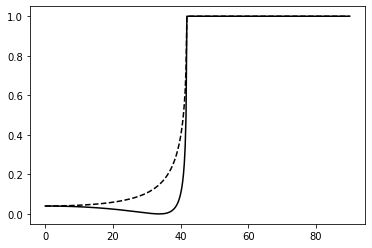

In [8]:
epsilon = (1.5**2, 1.5**2, 1.0**2)  
thickness = (1e3, 50, 1e3)    
polarisation = 'p'
theta = np.pi/4
wavelength=633.0

r, t = multilayer(wavelength, theta, epsilon, thickness, polarisation) 

Ntheta = 360
atheta = np.linspace(0.001, np.pi/2-0.001, Ntheta)
arp = np.zeros(Ntheta)
ars = np.zeros(Ntheta)
atp = np.zeros(Ntheta)
ats = np.zeros(Ntheta)

for it in range(Ntheta):
    theta = atheta[it]
    rp, tp = multilayer(wavelength, theta, epsilon, thickness, 'p') 
    rs, ts = multilayer(wavelength, theta, epsilon, thickness, 's') 
    arp[it] = rp; ars[it] = rs; atp[it] = tp; ats[it] = ts; 

atheta_deg = atheta * 180/np.pi

plt.figure()
plt.plot(atheta_deg, arp, '-k')
plt.plot(atheta_deg, ars,'--k')
plt.show()

## Distributed Bragg Reflector

This is a multilayer where the optical thickness of each layer is $\lambda/4$, leading to constructive interference in the reflection coefficient around the central wavelength. We define a helper function to return arrays of epsilon and thickness for such structures.

In [9]:
def dbr(lambda0, n1, n2, N):
    d1 = lambda0 / 4 / n1
    d2 = lambda0 / 4 / n2
    thickness = np.concatenate([[d1,d2] for _ in range(N)])
    epsilon = np.concatenate([[n1**2,n2**2] for _ in range(N)])
    
    return(epsilon, thickness)
    

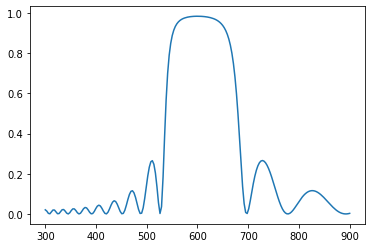

In [11]:
Nlambda = 200
wavelength = np.linspace(300, 900, Nlambda)
ar1 = np.zeros(Nlambda)
s1 = dbr(600, 2.0,1.5,  10)

for it in range(Nlambda):
    rp1, tp = multilayer(wavelength[it], 0.0, s1[0], s1[1], 'p') 
    ar1[it] = rp1

plt.figure()
plt.plot(wavelength, ar1)
plt.show()



## Drude model for the dielectric function of metals

Our next structure adds a gold layer on top of the DBR; because gold is very dispersive in the visible (it is yellow, for one thing), we need a wavelength-dependent dielectric function, defined below.

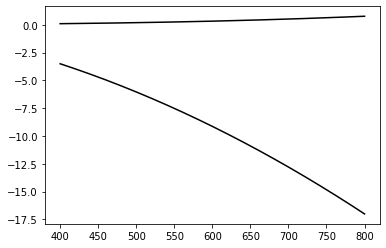

In [12]:
# this is approximately like gold in the red-near-IR part of the spectrum
def drude(wavelength, omega_p, gamma_p, epsilon_inf):
    
    omega = 2*np.pi*1e9 * 2.99792458e8 / wavelength
    epsilon = epsilon_inf -  omega_p**2 / (omega**2 +  1j * omega * gamma_p)
    return(epsilon)



import math
import matplotlib.pyplot as plt

Nlambda = 200
wavelength = np.linspace(400, 800, Nlambda)

e = [drude(l, 1e16, 1e14, 1) for l in wavelength]

plt.figure()
plt.plot(wavelength, np.real(e), '-k')
plt.plot(wavelength, np.imag(e), '-k')
plt.show()


## Tamm plasmon structure

Let's see what happens to the reflectivity of our DBR when we add a thin gold film on top. A mirror on top of a mirror, essentially. This structure supports optical modes called Tamm plasmons.

In [13]:
def tamm(lambda0, n1, n2, N, dm, epsm, nleft, nright):
    s1 = dbr(lambda0, n1, n2, N)
    epsilon = np.append(epsm, s1[0])
    epsilon = np.append(nleft**2, epsilon)
    epsilon = np.append(epsilon, nright**2)
    thickness = np.append(dm, s1[1])
    thickness = np.append(100, thickness)
    
    return(epsilon, thickness)
    

We now compare the results for the bare DBR, and the DBR coated with gold.

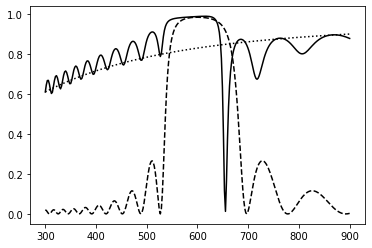

In [20]:
Nlambda = 300
wavelength = np.linspace(300, 900, Nlambda)
ar1 = np.zeros(Nlambda)
ar2 = np.zeros(Nlambda)
ar3 = np.zeros(Nlambda)

s1 = dbr(600, 2.0,1.5,  10)

for it in range(Nlambda):
    rp1, tp = multilayer(wavelength[it], 0.0, s1[0], s1[1], 'p') 
    epsm = drude(wavelength[it], 1e16, 1e14, 1)
    s2 = tamm(600, 2.0, 1.5, 10, 40, epsm, 1.0, 1.5)
    rp2, tp = multilayer(wavelength[it], 0.0, s2[0], s2[1], 'p') 
    
    # air/gold interface for reference
    epsilon = (1.0**2, epsm, 1.5**2)  
    thickness = (1e3, 40, 1e3)    
    rp3, tp = multilayer(wavelength[it], 0.0, epsilon, thickness, 'p') 
    ar1[it] = rp1; ar2[it] = rp2;ar3[it] = rp3;

plt.figure()
plt.plot(wavelength, ar1, '--k')
plt.plot(wavelength, ar2, '-k')
plt.plot(wavelength, ar3, ':k')
plt.show()



_Download this page [as a Jupyter notebook](https://github.com/vuw-scps/python-physics/raw/master/notebooks/phys415/multilayer.ipynb) or as a [standalone Python script](https://github.com/vuw-scps/python-physics/raw/master/scripts/phys415/multilayer.py)._